In [1]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, default_data_collator
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import os
from datasets import Dataset
import torch
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import string
from transformers import AutoTokenizer

2023-09-19 11:44:50.892003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 11:44:50.947455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 11:44:50.948229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 11:44:51.844518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to /home/CE/nursulu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [60]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from collections import defaultdict, Counter

In [4]:
cuda_id = ':0'
device = torch.device(f"cuda{cuda_id}" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [61]:
# Load the pre-trained T5 model and tokenizer
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

## Loading and preparing the dataset

In [62]:
text_column = "description"
label_column = "target"
max_length = 128
lr = 1e-2
num_epochs = 1
batch_size = 8

In [63]:
# Prepare your dataset and tokenize it
file_path = "coca_nouns_by_chat_gpt_5340.csv"

"""## Load Data and prepare Dataset"""
dataset_name = "targets_descriptions"

text_column = "description"
label_column = "target"
df = pd.read_csv(file_path)
df = df[:1000]

print(f"Number of descriptions: {len(df)}")
print(f"Number of target words: {df['target'].nunique()}")

df.head()

Number of descriptions: 1000
Number of target words: 1000


,target,description,type
0,principal,"The main or primary person, thing, or concept ...",NaN
1,percentage,It's the way we show parts of something in re...,NaN
2,survey,A method of collecting information or opinions...,NaN
3,set,"A collection of distinct objects, considered a...",NaN
4,day,"A period of approximately 24 hours, marked by ...",NaN


In [64]:
data = {"target": [word for word in df['target']], "description":[descr for descr in df['description']]}
dataset = Dataset.from_dict(data)
dataset_split = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
dataset_split['train'][0]

targets = dataset_split['train']['target']
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(target)["input_ids"]) for target in targets])
print(target_max_length)

7


In [65]:
dev_test = dataset_split["test"].train_test_split(test_size=0.5, shuffle=True, seed=42)
dataset_split["validation"] = dev_test['train']
dataset_split["test"] = dev_test['test']

In [66]:
dataset_split

DatasetDict({
    train: Dataset({
        features: ['target', 'description'],
        num_rows: 800
    })
    test: Dataset({
        features: ['target', 'description'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['target', 'description'],
        num_rows: 100
    })
})

In [67]:
def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    prefix = "Description: "
    suffix = " Word: "
    inputs = [prefix + input_text + suffix for input_text in inputs]

    model_inputs = tokenizer(inputs, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs

In [68]:
processed_datasets = dataset_split.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset_split["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

In [69]:
processed_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [70]:
train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [71]:
test_dataset = processed_datasets["test"]

## Training

In [72]:
model_name = "fine_tuned_flan_t5_small"
model_dir = f"/local/nursulu/bert_and_friends/{model_name}"

In [74]:
# Define training hyperparameters
training_args = TrainingArguments(
    output_dir=f"{model_dir}/model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="steps",
    eval_steps=20,
    save_total_limit=2,
)

# Create a Trainer instance for training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [75]:
# Create a TensorBoard SummaryWriter
tb_writer = SummaryWriter(log_dir=training_args.output_dir)  # Use the output_dir for TensorBoard logs

In [76]:
# Fine-tune the model
trainer.train()

/local/nursulu/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
20,No log,2.350105
40,No log,2.130923
60,No log,2.104228
80,No log,2.098252
100,No log,2.062244
120,No log,2.011095
140,No log,2.010171
160,No log,2.038436
180,No log,2.000894
200,No log,2.026709


TrainOutput(global_step=500, training_loss=2.0046171875, metrics={'train_runtime': 1767.3565, 'train_samples_per_second': 2.263, 'train_steps_per_second': 0.283, 'total_flos': 743562018816000.0, 'train_loss': 2.0046171875, 'epoch': 5.0})

## Evaluation

In [80]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

In [81]:
results

{'eval_loss': 2.0908145904541016,
 'eval_runtime': 11.1721,
 'eval_samples_per_second': 8.951,
 'eval_steps_per_second': 1.164,
 'epoch': 5.0}

In [79]:
# Save the model
model.save_pretrained(f"{model_dir}/model")

In [87]:
# Load the fine-tuned model for inference
fine_tuned_model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}/model")

# Generate predictions
input_text = "A yellow elongated fruit"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
output_ids = fine_tuned_model.generate(input_ids)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Generated word:", output_text)

Generated word: fruit


## Testing performance

In [83]:
def count_accuracy(pred, true, top_k=5):
  '''
  This function evaluates performance of the t5 family models on top-k candidates.
  '''
  accuracy = []
  rank_vs_accuracy = dict()
  for i in range(len(pred)): 
    ground_truth = true[i].strip().lower()
    #print("ground_truth:", ground_truth)
    preds = pred[i]
    #print("preds", preds)
    accuracy_sent = [1 if any(pred.strip().lower() == ground_truth for pred in preds[:top_k]) else 0]
    #print("accuracy_sent", accuracy_sent)
    accuracy.extend(accuracy_sent)
    rank_vs_accuracy[coca_words.index(ground_truth)] = accuracy_sent

  accuracy = sum(accuracy)
  accuracy /= len(pred)
  return [accuracy, rank_vs_accuracy]

In [84]:
def count_top_k_predictions(dataset, k=10, model=model):
    '''
    Count top-K predictions for each word + probabilities of these predictions
    '''
    
    descriptions = dataset['test']['description']
    targets = dataset['test']['target']

    inputs = [f"Descripton : {x}. Word : " for x in descriptions]

    inputs = tokenizer(
        inputs,
        padding=True, truncation=True,
        return_tensors="pt",
    )

    model.to(device)
    
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        output_sequences = model.generate(input_ids=inputs["input_ids"], max_new_tokens=10, num_beams=k, num_return_sequences=k, #max_length=3,
                                                    top_p = 50, output_scores=True, return_dict_in_generate=True) #repetition_penalty=10000.0
        #print("output_sequences", output_sequences)
        logits = torch.tensor(output_sequences['sequences_scores'])
        decoded_probabilities = torch.softmax(logits, dim=0)
        
        words_vs_probs = defaultdict()
        
        #all word predictions
        final_list = []
        for i in range(0, len(output_sequences['sequences']), k):
            sublist = output_sequences['sequences'][i:i + k]
            final_list.append(sublist)
        
        #all prediction probabilities
        final_probs = []
        for i in range(0, len(decoded_probabilities), k):
            sublist = decoded_probabilities[i:i + k]
            final_probs.append(sublist)
            
        predict_test = []
        
        for i in tqdm(range(len(targets))):
            words_vs_probs[(descriptions[i], targets[i])] = {}
            #print(sentences[i])
            preds = []
            for j in range(k):
                #print("Prediction number", j)
                predicted_token_ids = final_list[i][j]
                decoded_predictions = tokenizer.decode(predicted_token_ids, skip_special_tokens=True)
                words_vs_probs[(descriptions[i], targets[i])][decoded_predictions] = round(float(final_probs[i][j]), 3)
                preds.append(decoded_predictions)
            predict_test.append(preds)
    
    return [predict_test, words_vs_probs]

In [85]:
processed_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [86]:
coca_words = list(df['target'])
true = dataset_split['test']["target"]

In [89]:
predict_test, words_vs_probs = count_top_k_predictions(dataset_split, k=10, model=fine_tuned_model)

/tmp/ipykernel_228315/2970769765.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(output_sequences['sequences_scores'])
100%|██████████| 100/100 [00:00<00:00, 6687.67it/s]


In [90]:
# for key in words_vs_probs:
#     print(key)
#     print(words_vs_probs[key])

('It is similar to the beast or creature.', 'being')
{'creature': 0.003, 'beast': 0.001, 'adolf': 0.001, 'sacrifice': 0.001, 'adolescent': 0.001, 'acrobatic': 0.001, 'adolescence': 0.001, 'tawn': 0.001, 'adolf or ad': 0.001, 'tainted': 0.001}
('It is similar to concentration.', 'focus')
{'concentration': 0.001, 'adolescence': 0.001, 'systyrofoam': 0.001, 'psychiatric': 0.001, 'symbiosis': 0.001, 'psychiatry': 0.001, 'systylization': 0.001, 'systémium': 0.001, 'density': 0.001}
('It is similar to area, neighborhood, or region.', 'district')
{'neighborhood': 0.002, 'region': 0.002, 'neighbourhood': 0.001, 'area': 0.001, 'location': 0.001, 'town': 0.001, 'district': 0.001, 'city': 0.001, 'community': 0.001, 'description': 0.0}
('It is a synonym for trauma or damage.', 'injury')
{'trauma': 0.003, 'injury': 0.001, 'damage': 0.001, 'disease': 0.001, 'death': 0.001, 'tragedy': 0.0, 'illness': 0.0, 'cause': 0.0, 'traumatism': 0.0, 'trauma or damage': 0.0}
('Wet stuff that keeps us from being t

In [91]:
accuracy_100 = dict()
rank_vs_accuracy_100 = dict()
for i in range(1, 11):
  acc_100 = count_accuracy(predict_test, true, top_k=i)
  accuracy_100[i] = acc_100[0]
  rank_vs_accuracy_100[i] = acc_100[1]

In [92]:
accuracy_100

{1: 0.09,
 2: 0.24,
 3: 0.29,
 4: 0.36,
 5: 0.41,
 6: 0.44,
 7: 0.46,
 8: 0.48,
 9: 0.49,
 10: 0.49}

In [52]:
import matplotlib.pyplot as plt

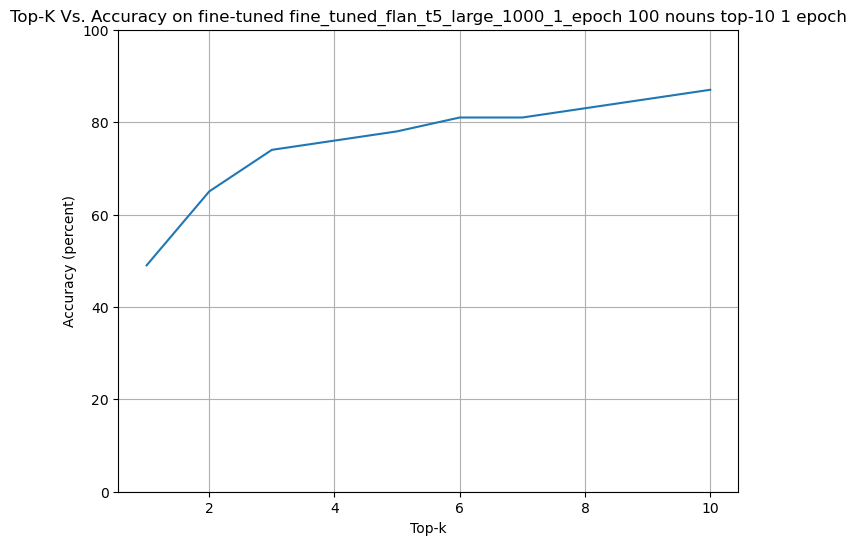

In [53]:
x = accuracy_100.keys()
y = [val * 100 for val in accuracy_100.values()]
plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(x, y)
plt.ylim(0, 100)
plt.grid(True)  # Add grid lines
plt.xlabel("Top-k")
plt.ylabel("Accuracy (percent)")
plt.title(f"Top-K Vs. Accuracy on fine-tuned {model_name} 100 nouns top-10 1 epoch")
plt.savefig(f'/local/nursulu/bert_and_friends/results/top_10_accuracy_fine_tuned_{model_name}_100_nouns_1_epoch.png')
plt.show()

## Saving model

In [54]:
from huggingface_hub import notebook_login

notebook_login()

In [59]:
peft_model_id = "NursNurs/T5ForReverseDictionary_fine-tuned"
fine_tuned_model.push_to_hub("NursNurs/T5ForReverseDictionary_fine-tuned", use_auth_token=True, create_pr=1)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NursNurs/T5ForReverseDictionary_fine-tuned/commit/9d0b7cd1fc25f4432c12af8e29b08002117e6a58', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='9d0b7cd1fc25f4432c12af8e29b08002117e6a58', pr_url='https://huggingface.co/NursNurs/T5ForReverseDictionary_fine-tuned/discussions/1', pr_revision='refs/pr/1', pr_num=1)